# Firstly, we imported necessary modules and set our settings on styling in the graphs. Then created a path to hold graphs pngs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import joblib

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create output directory
output_dir = 'ml_analysis_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"'{output_dir}' directory created")

# def load_and_enrich_data():
- This function orchestrates all of your raw inputs into a single, analytics-ready table. It reads the three CSVs (coffee & sleep, weather, academic calendar), parses and aligns their dates, and merges them on the common Date field. From there it derives dozens of new features: it converts sleep into hours and categorical buckets, computes lagged and rolling trends for sleep and coffee, extracts temporal attributes (day of week, weekend flag, week number), transforms weather into categories and composite “WeatherScore,” and builds academic stress indicators and a unified “StressScore.” After filling any gaps, it writes the fully enriched dataset to disk and prints a summary of what got added.

In [3]:
def load_and_enrich_data():
    """Load, merge and enrich datasets for ML"""
    print("Loading and enriching datasets...")
    
    # Coffee and sleep data
    coffee_sleep_file = 'raw_datas/coffee_sleep_data.csv'
    if not os.path.exists(coffee_sleep_file):
        print(f"Error: {coffee_sleep_file} file not found!")
        return None
    
    # Weather data
    weather_file = 'raw_datas/weather_data_istanbul.csv'
    if not os.path.exists(weather_file):
        print(f"Error: {weather_file} file not found!")
        return None
    
    # Academic calendar data
    academic_file = 'raw_datas/academic_calendar.csv'
    if not os.path.exists(academic_file):
        print(f"Error: {academic_file} file not found!")
        return None
    
    # Read data
    coffee_sleep_df = pd.read_csv(coffee_sleep_file)
    weather_df = pd.read_csv(weather_file)
    academic_df = pd.read_csv(academic_file)
    
    # Convert date columns to the correct format
    coffee_sleep_df['Date'] = pd.to_datetime(coffee_sleep_df['Date'], format='%d.%m.%Y')
    weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d.%m.%Y')
    academic_df['Date'] = pd.to_datetime(academic_df['Date'], format='%d.%m.%Y')
    
    # Convert boolean column to the correct format
    academic_df['DoYouHaveAnySubmissionOrExam'] = academic_df['DoYouHaveAnySubmissionOrExam'].map({'true': True, 'false': False})
    
    # If it's a string, convert the text to lowercase and compare with True/False
    if academic_df['DoYouHaveAnySubmissionOrExam'].dtype == 'object':
        academic_df['DoYouHaveAnySubmissionOrExam'] = academic_df['DoYouHaveAnySubmissionOrExam'].astype(str).str.lower().map({'true': True, 'false': False})
    
    # Match column names for merging
    weather_df.rename(columns={'date': 'Date'}, inplace=True)
    
    # Merge data (inner join - only dates available in both sets)
    merged_df = pd.merge(coffee_sleep_df, weather_df, on='Date', how='inner')
    merged_df = pd.merge(merged_df, academic_df, on='Date', how='inner')
    
    # FEATURE ENRICHMENT #
    
    # 1. Enrich sleep hours
    # 1.1 Convert sleep hours to minutes
    merged_df['SleepMinutes'] = merged_df['SleepingHours'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    merged_df['SleepHours'] = merged_df['SleepMinutes'] / 60
    
    # 1.2 Create sleep categories (Feature Transformation)
    merged_df['SleepCategory'] = pd.cut(
        merged_df['SleepHours'], 
        bins=[0, 6, 7, 10], 
        labels=['Insufficient', 'Normal', 'Sufficient']
    )
    
    # 1.3 Add previous day's sleep duration (Feature Enrichment - Time Series)
    merged_df['PreviousDaySleep'] = merged_df['SleepHours'].shift(1)
    
    # 1.4 Sleep trend (last 3 days trend) (Feature Enrichment - Time Series)
    merged_df['SleepTrend'] = merged_df['SleepHours'].rolling(window=3).mean().shift(1)
    
    # 2. Enrich temporal features
    # 2.1 Days of the week
    merged_df['DayOfWeek'] = merged_df['Date'].dt.day_name()
    merged_df['IsWeekend'] = merged_df['Date'].dt.dayofweek >= 5  # Weekend: True (5=Saturday, 6=Sunday)
    
    # 2.2 Week number 
    merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week
    
    # 3. Enrich weather features
    # 3.1 Temperature categories (Feature Transformation)
    merged_df['TemperatureCategory'] = pd.cut(
        merged_df['avg_temp'], 
        bins=[0, 8, 12, 16, 100], 
        labels=['Cold', 'Mild', 'Warm', 'Hot']
    )
    
    # 3.2 Precipitation categories (Feature Transformation)
    merged_df['PrecipitationCategory'] = pd.cut(
        merged_df['precipitation'], 
        bins=[-1, 0.1, 1, 5, 100], 
        labels=['None', 'Light', 'Moderate', 'Heavy']
    )
    
    # 3.3 Cloud cover categories (Feature Transformation & Cleaning)
    # Note: There are negative values in the dataset, these must be errors
    merged_df['cloud_cover'] = merged_df['cloud_cover'].apply(lambda x: max(0, min(x, 100)))  # Limit to 0-100 range
    merged_df['CloudCategory'] = pd.cut(
        merged_df['cloud_cover'], 
        bins=[0, 25, 50, 75, 100], 
        labels=['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast']
    )
    
    # 3.4 Weather score (Feature Engineering - Composite Feature)
    # Temperature + humidity + cloud cover combination (factor affecting coffee consumption likelihood)
    # Temperature: low=high score, Cloud cover: high=high score
    # Low temp, high cloud cover = high desire for coffee
    merged_df['WeatherScore'] = (
        (20 - merged_df['avg_temp']) * 0.5 +  # Low temperature → high score 
        merged_df['cloud_cover'] * 0.3 +       # High cloud cover → high score
        merged_df['precipitation'] * 2         # Precipitation → high score
    )
    
    # 4. Enrich academic stress score (Feature Engineering)
    # 4.1 Number of upcoming exams/assignments in the last 3 days
    merged_df['UpcomingAcademicEvents'] = merged_df['DoYouHaveAnySubmissionOrExam'].rolling(window=3).sum().shift(-2)
    merged_df['UpcomingAcademicEvents'] = merged_df['UpcomingAcademicEvents'].fillna(0)
    
    # 4.2 Number of recent exams/assignments (last 2 days)
    merged_df['RecentAcademicEvents'] = merged_df['DoYouHaveAnySubmissionOrExam'].rolling(window=2).sum().shift(1)
    merged_df['RecentAcademicEvents'] = merged_df['RecentAcademicEvents'].fillna(0)
    
    # 5. Enrich coffee consumption history (Feature Enrichment - Time Series)
    # 5.1 Previous day coffee consumption
    merged_df['PreviousDayCoffee'] = merged_df['CupsOfCoffee'].shift(1)
    
    # 5.2 Last 3 days average coffee consumption
    merged_df['CoffeeTrend'] = merged_df['CupsOfCoffee'].rolling(window=3).mean().shift(1)
    
    # 6. Composite stress score (Feature Engineering - Composite Feature)
    merged_df['StressScore'] = (
        (7 - merged_df['SleepHours']) * 3 +                # Less sleep → high stress
        merged_df['UpcomingAcademicEvents'] * 2 +          # Upcoming academic events → high stress
        merged_df['RecentAcademicEvents'] * 1 +            # Past academic events → moderate stress
        (merged_df['WeatherScore'] / 10)                   # Bad weather → slight stress
    )
    
    # Fill NaN values
    merged_df = merged_df.fillna({
        'PreviousDaySleep': merged_df['SleepHours'].mean(),
        'SleepTrend': merged_df['SleepHours'].mean(),
        'PreviousDayCoffee': merged_df['CupsOfCoffee'].mean(),
        'CoffeeTrend': merged_df['CupsOfCoffee'].mean(),
        'UpcomingAcademicEvents': 0,
        'RecentAcademicEvents': 0
    })
    
    # Save enriched dataset
    enriched_file = f'{output_dir}/enriched_coffee_data.csv'
    merged_df.to_csv(enriched_file, index=False)
    print(f"Enriched dataset saved to {enriched_file}.")
    
    # Show summary of added/transformed features
    print("\nEnriched Features:")
    new_features = [
        'SleepHours', 'SleepCategory', 'PreviousDaySleep', 'SleepTrend',
        'DayOfWeek', 'IsWeekend', 'WeekOfYear',
        'TemperatureCategory', 'PrecipitationCategory', 'CloudCategory', 'WeatherScore',
        'UpcomingAcademicEvents', 'RecentAcademicEvents',
        'PreviousDayCoffee', 'CoffeeTrend', 'StressScore'
    ]
    
    for feature in new_features:
        if feature in merged_df.columns:
            # Check if the feature is categorical
            if merged_df[feature].dtype.name == 'category':
                print(f"- {feature}: {merged_df[feature].cat.categories.tolist()}")
            # Check if the feature is boolean
            elif merged_df[feature].dtype == bool:
                print(f"- {feature}: Boolean feature")
            # Check if the feature is string type
            elif merged_df[feature].dtype == object:
                unique_values = merged_df[feature].unique()
                if len(unique_values) <= 10:  # If there are few unique values, show them
                    print(f"- {feature}: {list(unique_values)}")
                else:
                    print(f"- {feature}: Text feature with {len(unique_values)} unique values")
            # For numeric features, show min, max, mean
            else:
                print(f"- {feature}: min={merged_df[feature].min():.2f}, max={merged_df[feature].max():.2f}, mean={merged_df[feature].mean():.2f}")
    
    return merged_df

# def visualize_enriched_features(df):
- It turns those new columns into insight through plots. It first shows how the composite StressScore relates to coffee use (with regression and correlation), then loops through each categorical enrichment (sleep category, temperature bin, precipitation bin, cloud cover, day of week) to draw boxplots of coffee cups by category. Finally, it renders a heatmap of the full numeric correlation matrix, revealing which enriched variables most closely track caffeine consumption.

In [4]:
def visualize_enriched_features(df):
    """Visualize enriched features"""
    print("\nCreating visualizations of enriched features...")
    
    # 1. Relationship between stress score and coffee consumption
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='StressScore', y='CupsOfCoffee', hue='IsWeekend', 
                    size='CupsOfCoffee', sizes=(50, 200), 
                    palette='viridis', data=df)
    
    # Regression line
    sns.regplot(x='StressScore', y='CupsOfCoffee', data=df, scatter=False, 
                line_kws={"color":"red", "alpha":0.7, "lw":2, "ls":"--"})
    
    plt.xlabel('Stress Score')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Relationship Between Stress Score and Coffee Consumption')
    
    # Add correlation value
    corr = df['StressScore'].corr(df['CupsOfCoffee'])
    plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.legend(title='Weekend')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/stress_coffee_relationship.png')
    
    # 2. Relationship between coffee consumption and all categorical variables
    categorical_features = ['SleepCategory', 'TemperatureCategory', 'PrecipitationCategory', 
                           'CloudCategory', 'DayOfWeek']
    
    fig, axes = plt.subplots(len(categorical_features), 1, figsize=(12, 4*len(categorical_features)))
    
    for i, feature in enumerate(categorical_features):
        if feature in df.columns:
            sns.boxplot(x=feature, y='CupsOfCoffee', data=df, ax=axes[i])
            axes[i].set_title(f'Relationship Between {feature} and Coffee Consumption')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Number of Coffee Cups')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/categorical_variables_coffee_relationship.png')
    
    # 3. Feature correlation matrix
    numeric_cols = [
        'CupsOfCoffee', 'SleepHours', 'avg_temp', 'precipitation', 
        'cloud_cover', 'PreviousDaySleep', 'SleepTrend', 'WeatherScore',
        'UpcomingAcademicEvents', 'RecentAcademicEvents', 'PreviousDayCoffee',
        'CoffeeTrend', 'StressScore'
    ]
    
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    plt.figure(figsize=(14, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Enriched Features')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/enriched_correlation_matrix.png')

# def prepare_data_for_ml(df):
- This function splits the enriched table into features (X) and target (y = CupsOfCoffee), identifies which columns are categorical versus numerical, and then performs a reproducible 75/25 train-test split. It returns the four splits plus the two feature lists, laying the groundwork for any downstream modeling or selection pipeline.

In [6]:
def prepare_data_for_ml(df):
    """Prepare data for ML: X and y split, train-test split"""
    print("\nPreparing data for ML...")
    
    # Target variable
    y = df['CupsOfCoffee']
    
    # Categorical and numerical features
    categorical_features = ['SleepCategory', 'DayOfWeek', 'IsWeekend', 
                            'TemperatureCategory', 'PrecipitationCategory', 'CloudCategory']
    
    numerical_features = ['SleepHours', 'PreviousDaySleep', 'SleepTrend', 
                           'avg_temp', 'precipitation', 'cloud_cover', 'WeatherScore',
                           'UpcomingAcademicEvents', 'RecentAcademicEvents',
                           'PreviousDayCoffee', 'CoffeeTrend', 'StressScore']
    
    # Check available columns
    categorical_features = [f for f in categorical_features if f in df.columns]
    numerical_features = [f for f in numerical_features if f in df.columns]
    
    # Features
    X = df[categorical_features + numerical_features]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, categorical_features, numerical_features

# build_and_evaluate_models(X_train, X_test, y_train, y_test, categorical_features, numerical_features):
- Finally, stitches together end-to-end ML experiments. It defines a preprocessing pipeline (mean‐imputation + scaling for numerics, mode‐imputation + one-hot for categoricals), then iterates through six model classes (Linear, Ridge, Lasso, Random Forest, Gradient Boosting, SVR). For each, it fits on the training folds, predicts on the test set, computes MSE, RMSE, MAE, and R², and prints the metrics. For tree-based models it also extracts and plots the top feature importances. Once all models are compared, it identifies the best by R², trains a final pipeline on the full training data, saves that model to disk, and produces summary charts comparing performance and feature importances.










In [7]:
def build_and_evaluate_models(X_train, X_test, y_train, y_test, categorical_features, numerical_features):
    """Build, train and evaluate ML models"""
    print("\nBuilding and evaluating ML models...")
    
    # Create data transformation pipelines for preprocessing
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combined preprocessor for categorical and numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Model definitions
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "Support Vector Regression": SVR(kernel='rbf')
    }
    
    # Create, train and evaluate pipeline for each model
    results = {}
    feature_importances = {}
    
    for name, model in models.items():
        print(f"\nModel: {name} is being trained and evaluated...")
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Model training
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # Performance metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Save results
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
        
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
        
        # Feature importances (for models that support it)
        if hasattr(model, 'feature_importances_'):
            # Feature names after preprocessor
            preprocessor.fit(X_train)
            
            # Feature names after one-hot-encoding for categorical variables
            cat_features = []
            if categorical_features:
                cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
                cat_features = cat_encoder.get_feature_names_out(categorical_features)
            
            # All feature names
            feature_names = np.concatenate([numerical_features, cat_features])
            
            # Feature importances
            importances = model.feature_importances_
            
            # Store top 10 most important features
            indices = np.argsort(importances)[::-1][:min(10, len(feature_names))]
            top_features = {feature_names[i]: importances[i] for i in indices}
            feature_importances[name] = top_features
    
    # Select best model
    best_model = max(results, key=lambda k: results[k]['R2'])
    print(f"\nBest model: {best_model} (R2: {results[best_model]['R2']:.4f})")
    
    # Visualize results
    # 1. Model performance comparison
    plt.figure(figsize=(12, 6))
    model_names = list(results.keys())
    r2_scores = [results[model]['R2'] for model in model_names]
    rmse_scores = [results[model]['RMSE'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(14, 7))
    bar1 = ax1.bar(x - width/2, r2_scores, width, label='R² Score', color='steelblue')
    ax1.set_ylabel('R² Score')
    ax1.set_ylim(0, 1)
    
    ax2 = ax1.twinx()
    bar2 = ax2.bar(x + width/2, rmse_scores, width, label='RMSE', color='coral')
    ax2.set_ylabel('RMSE')
    
    ax1.set_xlabel('Model')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title('ML Models Performance Comparison')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/model_performance_comparison.png')
    
    # 2. Feature importances for best model (if available)
    if best_model in feature_importances:
        plt.figure(figsize=(12, 6))
        features = list(feature_importances[best_model].keys())
        importances = list(feature_importances[best_model].values())
        
        sns.barplot(x=importances, y=features)
        plt.title(f'{best_model} - Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/best_model_feature_importances.png')
    
    # Save best model
    best_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models[best_model])
    ])
    best_pipeline.fit(X_train, y_train)
    
    joblib.dump(best_pipeline, f'{output_dir}/best_coffee_prediction_model.pkl')
    print(f"Best model saved to '{output_dir}/best_coffee_prediction_model.pkl'.")
    
    return results, best_model

# feature_selection_analysis(X_train, y_train, categorical_features, numerical_features):
- The routine applies a RandomForestRegressor within an RFE (Recursive Feature Elimination) framework to evaluate various shortlist sizes (3, 5, 7, 10, 15). It preprocesses via imputation, scaling, and one-hot encoding, runs RFE for each candidate number of features, and reports which variables survive as the top predictors. It also visualizes the full ranking (for the largest subset) so you can see at a glance which engineered features matter most.

In [8]:
def feature_selection_analysis(X_train, y_train, categorical_features, numerical_features):
    """Feature selection analysis - using RFE"""
    print("\nPerforming feature selection analysis...")
    
    # Preprocessing pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Transform data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    
    # Feature names
    cat_features = []
    if categorical_features:
        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_features = cat_encoder.get_feature_names_out(categorical_features)
    
    feature_names = np.concatenate([numerical_features, cat_features])
    
    # Model for RFE
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # RFE with different numbers of features
    n_features_to_select_options = [3, 5, 7, 10, 15]
    results = {}
    
    for n in n_features_to_select_options:
        if n <= X_train_preprocessed.shape[1]:
            # Apply RFE
            selector = RFE(estimator, n_features_to_select=n, step=1)
            selector = selector.fit(X_train_preprocessed, y_train)
            
            # Selected features
            selected_features_mask = selector.support_
            selected_features = feature_names[selected_features_mask]
            
            results[n] = {
                'selected_features': selected_features,
                'ranking': selector.ranking_
            }
    
    # Print results
    print("\nFeature Selection Results:")
    for n, result in results.items():
        print(f"\nTop {n} most important features:")
        for feature in result['selected_features']:
            print(f"- {feature}")
    
    # Visualize results
    if results:
        # Feature importance ranking
        plt.figure(figsize=(12, 8))
        
        # Get ranking from last RFE
        last_n = max(n_features_to_select_options)
        if last_n in results:
            rankings = results[last_n]['ranking']
            
            # Put features and their rankings in a dictionary
            feature_rankings = {str(feature): rank for feature, rank in zip(feature_names, rankings)}
            
            # Sort by ranking (lower values are more important)
            sorted_features = sorted(feature_rankings.items(), key=lambda x: x[1])
            
            features = [feature for feature, _ in sorted_features]
            ranks = [rank for _, rank in sorted_features]
            
            plt.figure(figsize=(10, 12))
            sns.barplot(x=ranks, y=features)
            plt.title('Feature Importance Ranking (RFE)')
            plt.xlabel('Ranking (lower=more important)')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.savefig(f'{output_dir}/feature_ranking_rfe.png')
    
    return results

In [9]:
"""Main function: Runs all analyses"""
print("Coffee Consumption Machine Learning Analysis")
print("========================================\n")

# Load and enrich data
df = load_and_enrich_data()

if df is None or df.empty:
    print("Error: Data could not be loaded or enriched.")

Coffee Consumption Machine Learning Analysis

Loading and enriching datasets...
Enriched dataset saved to ml_analysis_output/enriched_coffee_data.csv.

Enriched Features:
- SleepHours: min=5.88, max=8.42, mean=7.22
- SleepCategory: ['Insufficient', 'Normal', 'Sufficient']
- PreviousDaySleep: min=5.90, max=8.42, mean=7.25
- SleepTrend: min=6.23, max=8.08, mean=7.24
- DayOfWeek: ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']
- IsWeekend: Boolean feature
- WeekOfYear: min=11.00, max=17.00, mean=13.80
- TemperatureCategory: ['Cold', 'Mild', 'Warm', 'Hot']
- PrecipitationCategory: ['None', 'Light', 'Moderate', 'Heavy']
- CloudCategory: ['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast']
- WeatherScore: min=4.30, max=48.20, mean=21.88
- UpcomingAcademicEvents: min=0.00, max=2.00, mean=0.68
- RecentAcademicEvents: min=0.00, max=2.00, mean=0.45
- PreviousDayCoffee: min=0.00, max=4.00, mean=1.56
- CoffeeTrend: min=0.33, max=3.33, mean=1.53
- StressScore: min=


Creating visualizations of enriched features...


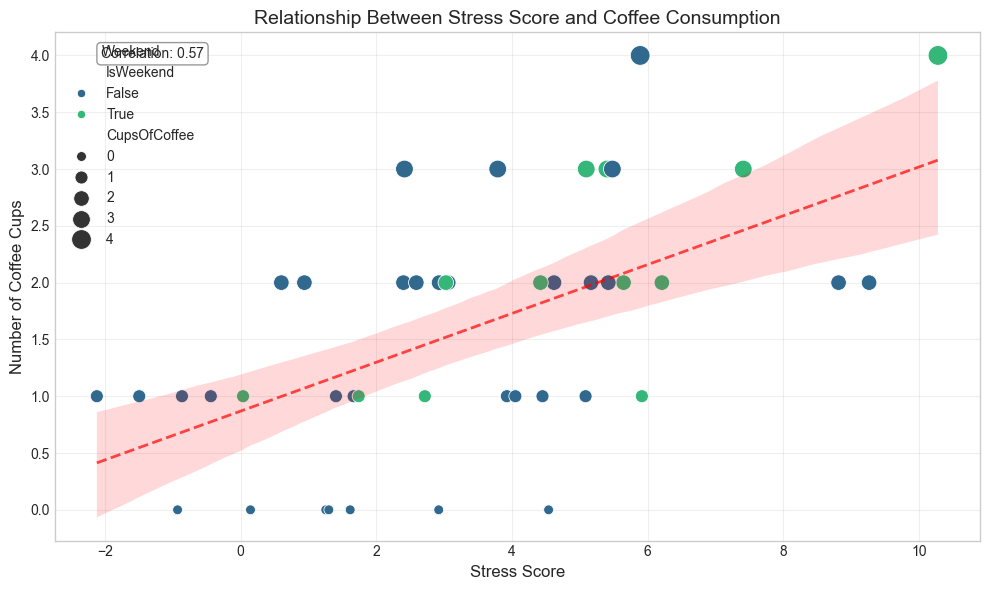

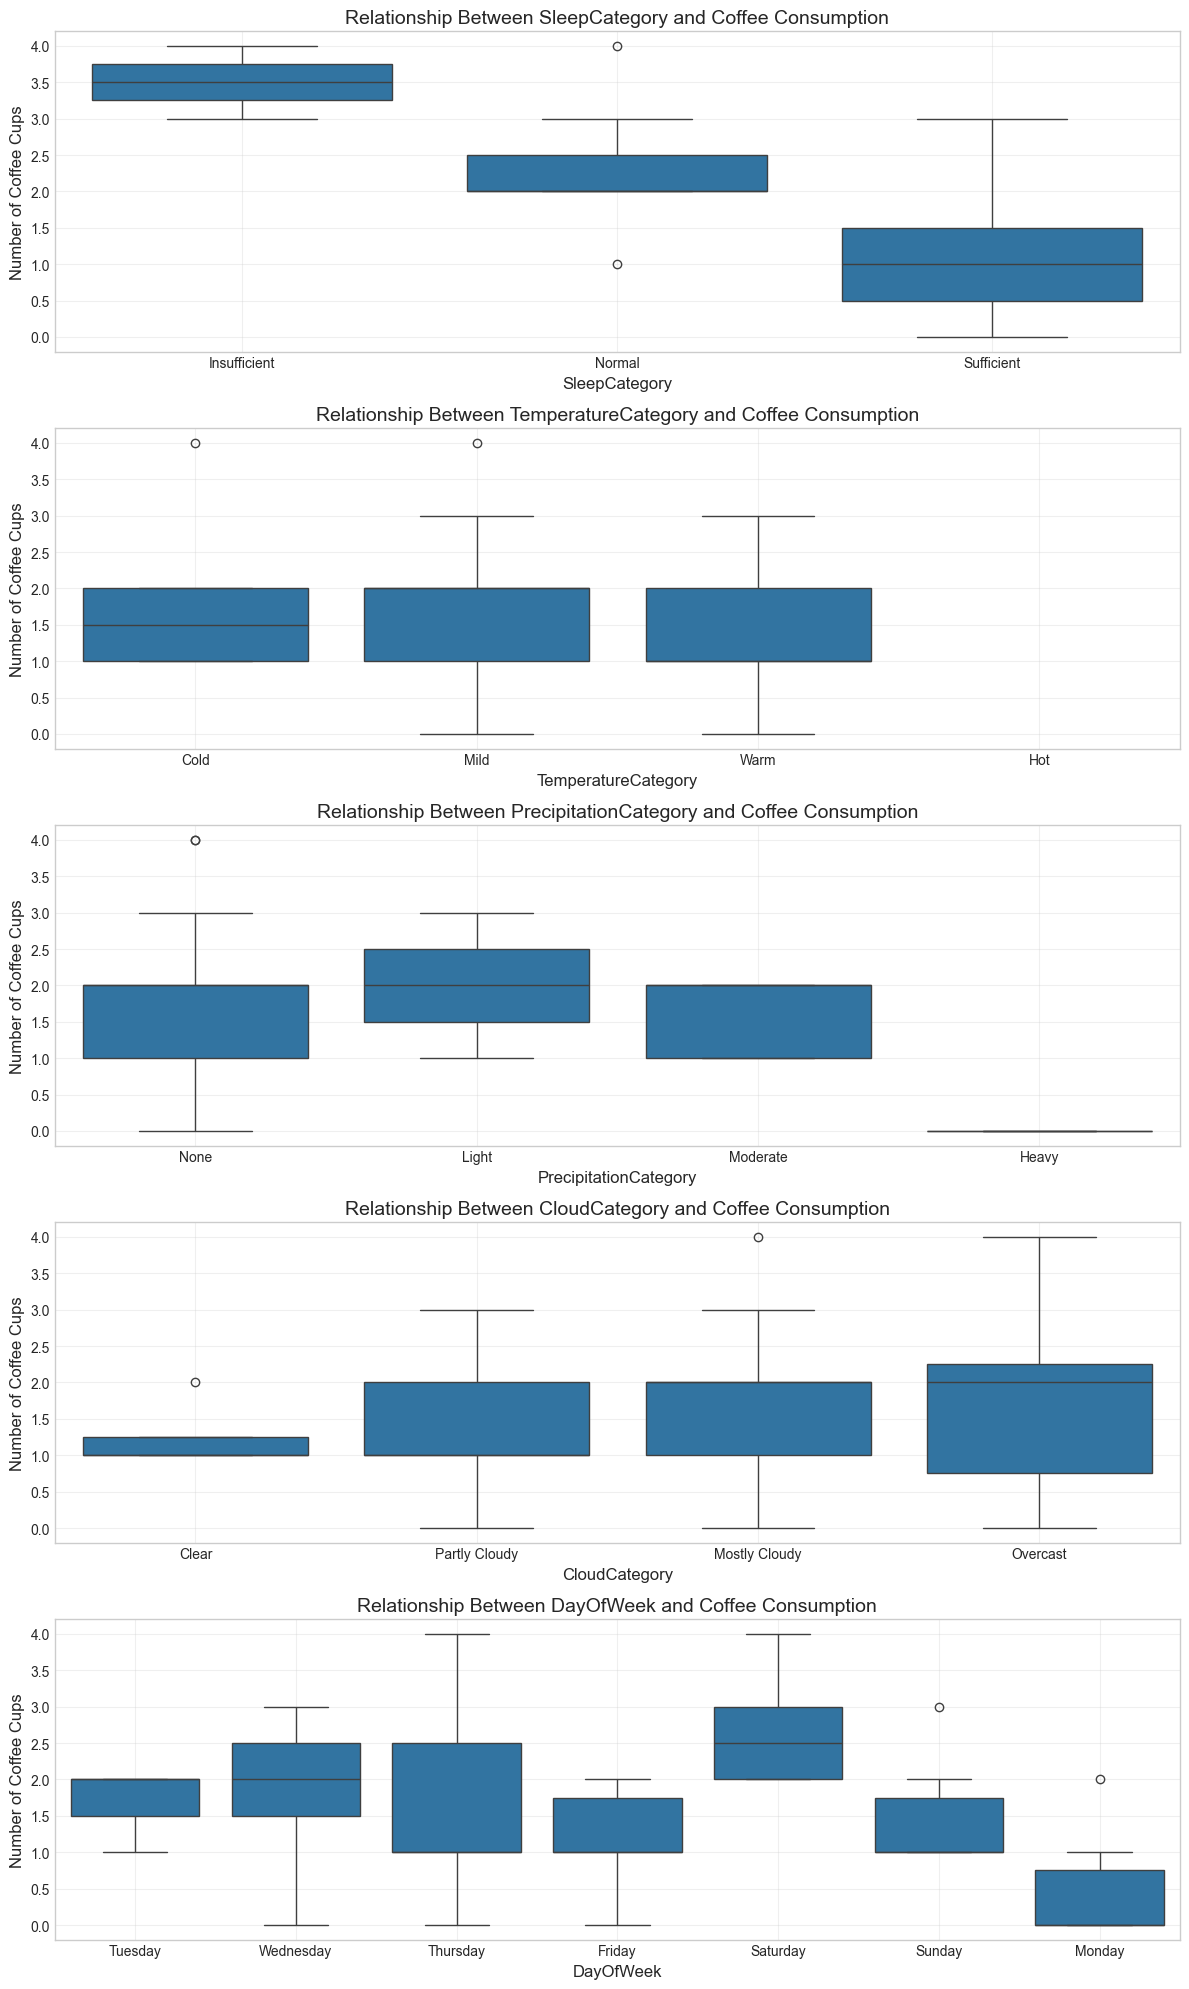

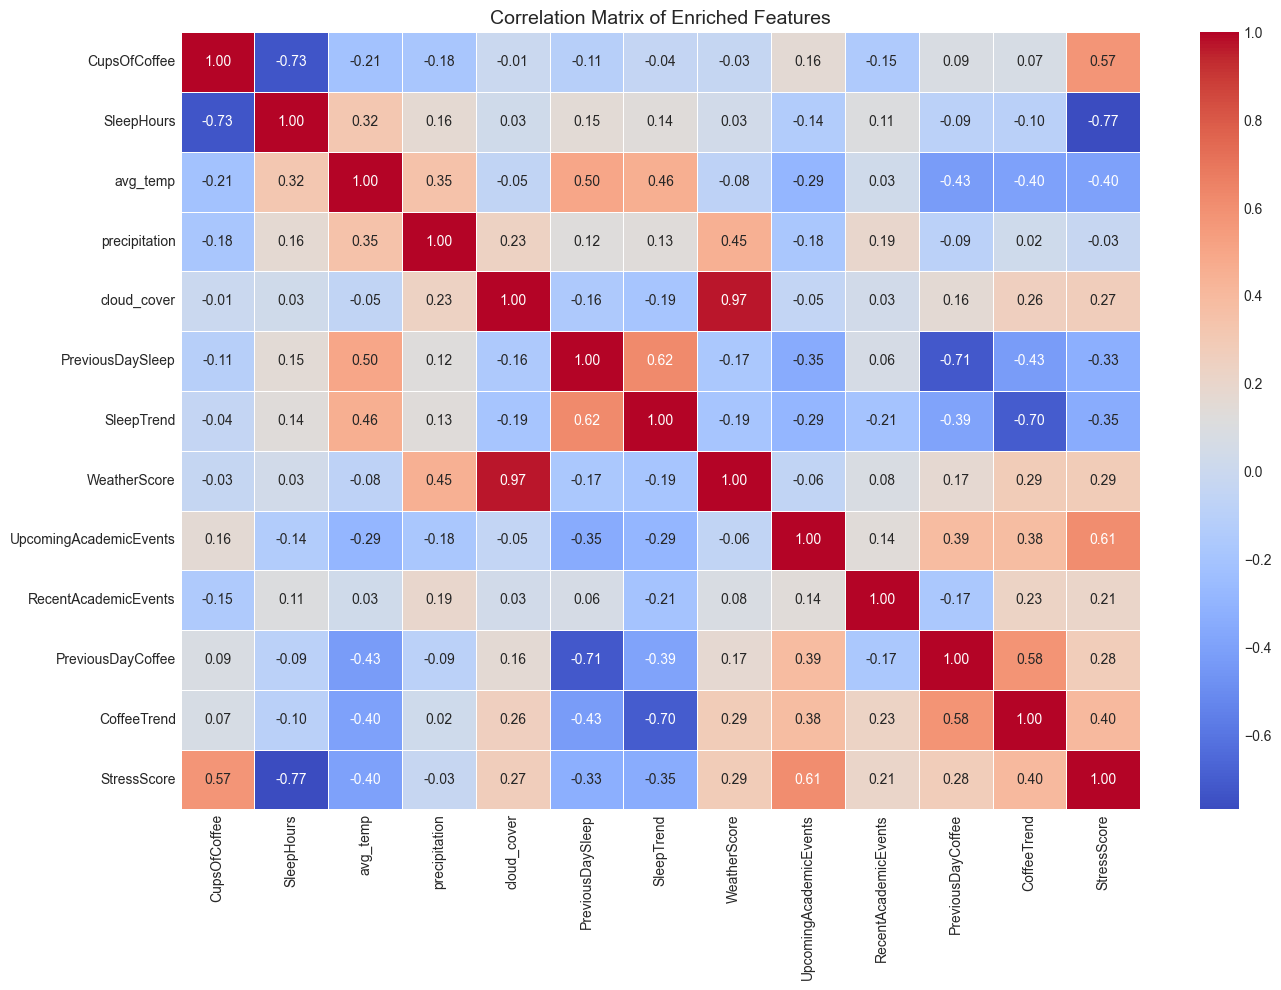

In [10]:
# Visualize enriched features
visualize_enriched_features(df)

In [11]:
# Prepare data for ML
X_train, X_test, y_train, y_test, categorical_features, numerical_features = prepare_data_for_ml(df)


Preparing data for ML...
Training set size: (33, 18)
Test set size: (11, 18)



Performing feature selection analysis...

Feature Selection Results:

Top 3 most important features:
- SleepHours
- SleepTrend
- avg_temp

Top 5 most important features:
- SleepHours
- SleepTrend
- avg_temp
- StressScore
- DayOfWeek_Thursday

Top 7 most important features:
- SleepHours
- PreviousDaySleep
- SleepTrend
- avg_temp
- WeatherScore
- StressScore
- DayOfWeek_Thursday

Top 10 most important features:
- SleepHours
- PreviousDaySleep
- SleepTrend
- avg_temp
- cloud_cover
- WeatherScore
- CoffeeTrend
- StressScore
- SleepCategory_Sufficient
- DayOfWeek_Thursday

Top 15 most important features:
- SleepHours
- PreviousDaySleep
- SleepTrend
- avg_temp
- cloud_cover
- WeatherScore
- PreviousDayCoffee
- CoffeeTrend
- StressScore
- SleepCategory_Sufficient
- DayOfWeek_Thursday
- DayOfWeek_Tuesday
- DayOfWeek_Wednesday
- TemperatureCategory_Cold
- TemperatureCategory_Mild


<Figure size 1200x800 with 0 Axes>

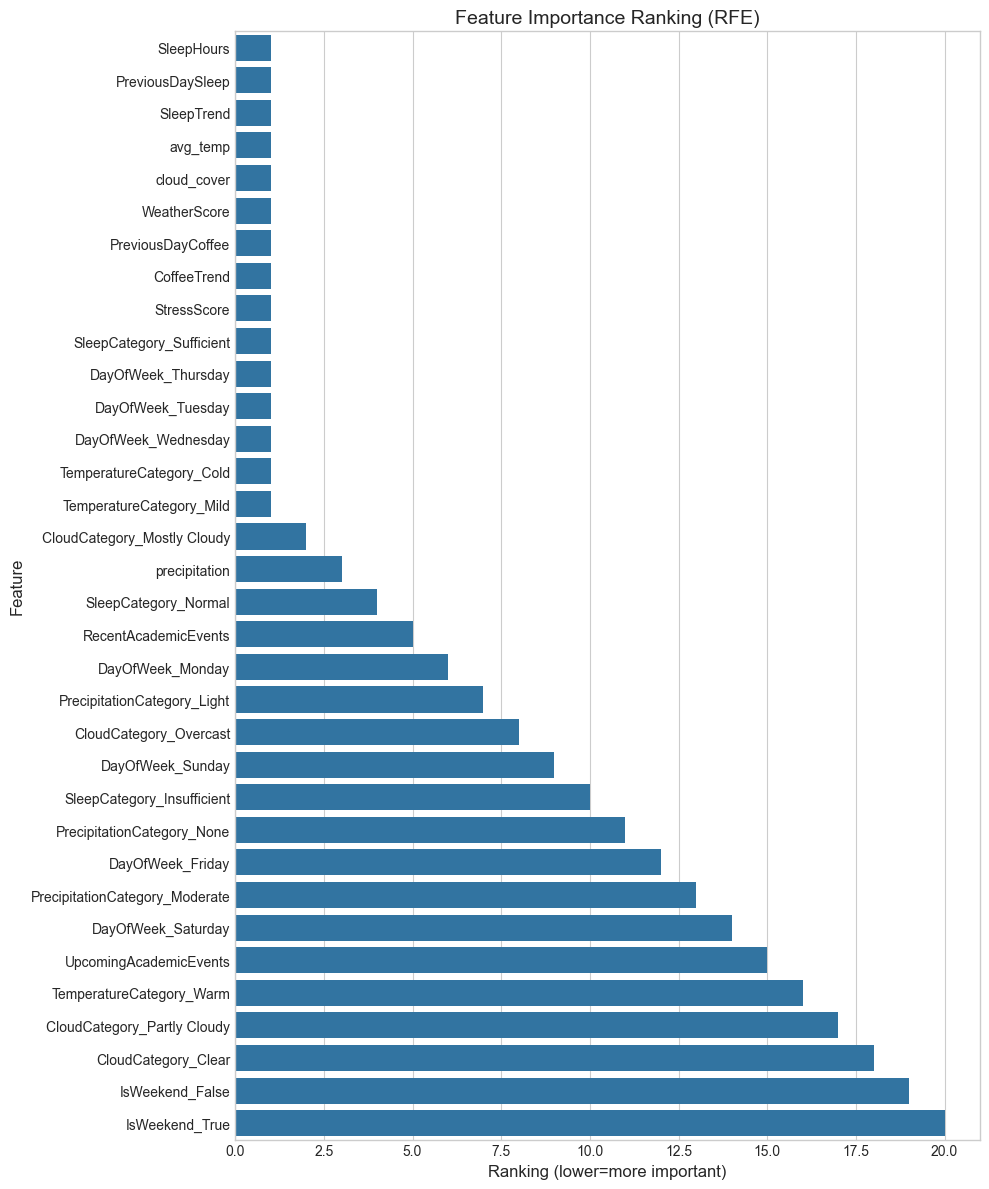

In [12]:
# Feature selection analysis
feature_selection_results = feature_selection_analysis(X_train, y_train, categorical_features, numerical_features)


Building and evaluating ML models...

Model: Linear Regression is being trained and evaluated...
MSE: 8.9917, RMSE: 2.9986, MAE: 2.4614, R2: -4.2815

Model: Ridge Regression is being trained and evaluated...
MSE: 2.4996, RMSE: 1.5810, MAE: 1.2595, R2: -0.4682

Model: Lasso Regression is being trained and evaluated...
MSE: 0.5587, RMSE: 0.7475, MAE: 0.6211, R2: 0.6718

Model: Random Forest is being trained and evaluated...
MSE: 0.7578, RMSE: 0.8705, MAE: 0.6773, R2: 0.5549

Model: Gradient Boosting is being trained and evaluated...
MSE: 0.8966, RMSE: 0.9469, MAE: 0.7170, R2: 0.4733

Model: Support Vector Regression is being trained and evaluated...
MSE: 1.2079, RMSE: 1.0990, MAE: 0.8881, R2: 0.2905

Best model: Lasso Regression (R2: 0.6718)
Best model saved to 'ml_analysis_output/best_coffee_prediction_model.pkl'.


<Figure size 1200x600 with 0 Axes>

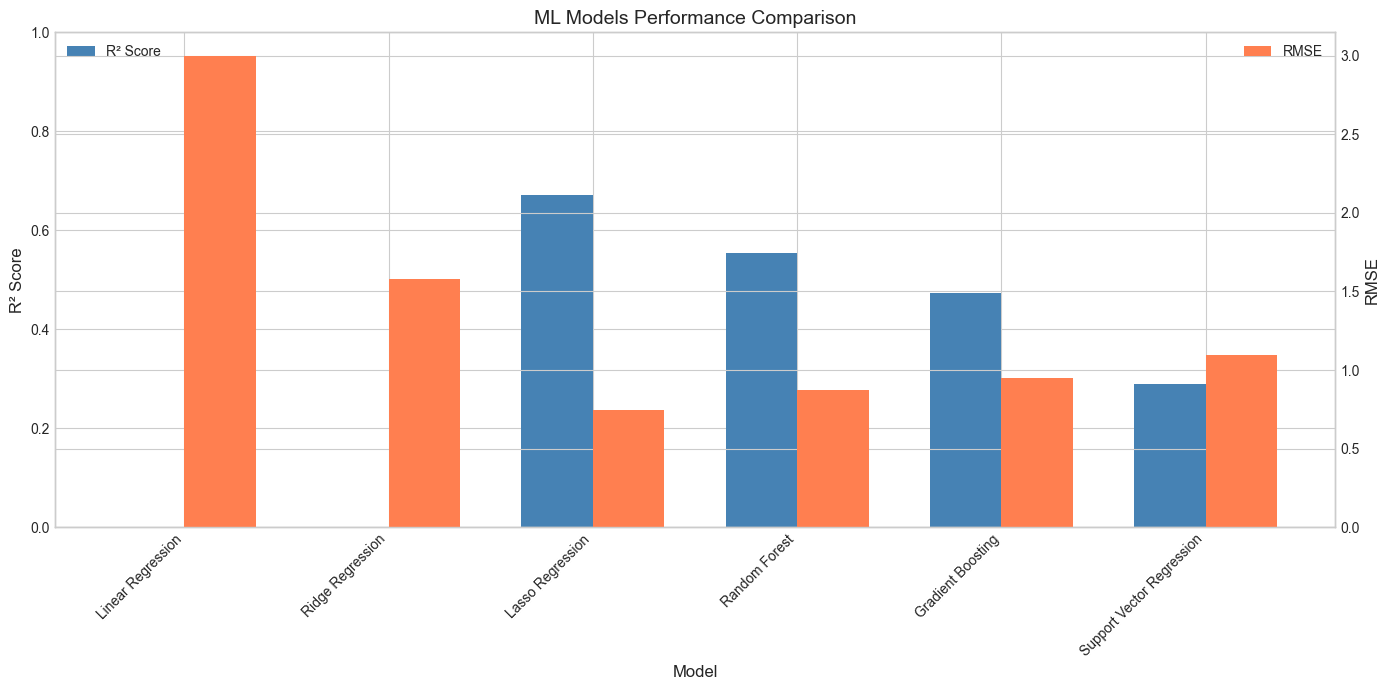

In [13]:
# Build and evaluate ML models
model_results, best_model = build_and_evaluate_models(
    X_train, X_test, y_train, y_test, 
    categorical_features, numerical_features
)